**Anna Smith**

**GitHub username: acs-233**

**Imperial College London - MSc EDSML - IRP**
# **Exploratory Data Analysis: $\textnormal{CO}_2$ Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from pathlib import Path
from bayareaco2.preprocessing.features import plot_nodes_gdf

## Getting study site node sample

In [2]:
# Reading in sensor location csv
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'get_latest_nodes.csv'
nodes = pd.read_csv(path)

# Filtering out nodes in study site
bay_area_nodes = nodes[(nodes['lat'] > 37.50) & (nodes['lat'] < 38.35) & (nodes['lng'] > -122.70) & (nodes['lng'] < -121.95)]

bay_area_nodes

# Selecting relevant variables
bay_area_nodes = bay_area_nodes[['id', 'node_name_long', 'lat', 'lng']]

# Manually adding one missing node
node_32 = {'id':32, 'node_name_long':'Park Day', 'lat':37.831590, 'lng':-122.257480}

# Concatenating with existing node data
new_nodes = pd.DataFrame([node_32])
bay_area_nodes = pd.concat([bay_area_nodes, new_nodes], ignore_index=True)

# Investigating Bay Area node data
bay_area_nodes

,id,node_name_long,lat,lng
0,1,Stone Edge Farms (Vineyard),38.29100,-122.50600
1,2,Stone Edge Farms (Turbine),38.28900,-122.50300
2,3,Piedmont High School,37.82400,-122.23300
3,4,Montclair Elementary School,37.83100,-122.21300
4,5,Port of Oakland,37.79600,-122.27900
...,...,...,...,...
73,281,Oxford Tract Greenhouse,37.87600,-122.26700
74,286,Paradise Park,37.84700,-122.28000
75,290,Lincoln Middle School Alameda,37.75300,-122.23100
76,318,Southeast Community Center (SECC),37.74300,-122.38700


## Investigating Full $\textnormal{CO}_2$ data

In [3]:
# Reading in BEACO2N data
folder_path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'BEACO2N_2012_01_01_to_2024_06_03'
csv_files = list(folder_path.glob('*.csv'))

# Combining all site-specific .csv files into one df
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file, nrows=1)
        if df.empty:
            print(f"Skipping empty file: {file}")
            continue
        df = pd.read_csv(file)
        dataframes.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {file}")

df = pd.concat(dataframes, ignore_index=True)

print(f"Number of observations: " + str(len(df)))

Skipping empty file: /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/BEACO2N_2012_01_01_to_2024_06_03/pinole_start_2012-01-01 14:00:00_end_2024-06-03 14:00:00_measurements.csv
Number of observations: 2464246


In [4]:
# Viewing original data
df.head()

,local_timestamp,epoch,datetime,node_file_id,co2_corrected_avg_t_drift_applied-level-2,temp,pressure,rh,node_id
0,2022-05-08 17:00:00,1.652054e+09,2022-05-09 00:00:00,2756050,-999.0,23.217439,1004.665370,26.148679,280
1,2022-05-08 18:00:00,1.652058e+09,2022-05-09 01:00:00,2756051,-999.0,23.240469,1004.410602,26.198903,280
2,2022-05-08 19:00:00,1.652062e+09,2022-05-09 02:00:00,2756052,-999.0,23.246841,1004.620011,25.805411,280
3,2022-05-08 20:00:00,1.652065e+09,2022-05-09 03:00:00,2756053,-999.0,23.227490,1004.956561,25.341082,280
4,2022-05-08 21:00:00,1.652069e+09,2022-05-09 04:00:00,2756054,-999.0,23.215657,1005.738207,25.347084,280


In [5]:
# Dropping inrrelevant variables
df.drop(columns=['epoch', 'datetime', 'node_file_id'], inplace=True)
df = df[['node_id', 'local_timestamp', 'co2_corrected_avg_t_drift_applied-level-2', 'temp', 'pressure', 'rh']].rename(columns={'local_timestamp':'timestamp', 'co2_corrected_avg_t_drift_applied-level-2':'co2'})

# Adding helper datetime variables
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['date'] = df['timestamp'].dt.date

In [6]:
df

,node_id,timestamp,co2,temp,pressure,rh,year,month,date
0,280,2022-05-08 17:00:00,-999.000000,23.217439,1004.665370,26.148679,2022,5,2022-05-08
1,280,2022-05-08 18:00:00,-999.000000,23.240469,1004.410602,26.198903,2022,5,2022-05-08
2,280,2022-05-08 19:00:00,-999.000000,23.246841,1004.620011,25.805411,2022,5,2022-05-08
3,280,2022-05-08 20:00:00,-999.000000,23.227490,1004.956561,25.341082,2022,5,2022-05-08
4,280,2022-05-08 21:00:00,-999.000000,23.215657,1005.738207,25.347084,2022,5,2022-05-08
...,...,...,...,...,...,...,...,...,...
2464241,51,2024-03-18 06:00:00,440.371434,11.841589,1005.303160,78.312330,2024,3,2024-03-18
2464242,51,2024-03-18 07:00:00,454.085831,11.326005,1005.627411,77.408000,2024,3,2024-03-18
2464243,51,2024-03-18 08:00:00,440.770690,12.280668,1006.036349,77.101930,2024,3,2024-03-18
2464244,51,2024-03-18 09:00:00,429.737452,14.730266,1006.339326,70.066189,2024,3,2024-03-18


In [7]:
# Merging valid co2 data with node location data
df = pd.merge(df, bay_area_nodes, left_on='node_id', right_on='id', how='inner')
df.drop(columns=['id'], inplace=True)

In [8]:
# Getting number of sensors/nodes represented in the data
print(f"Number of nodes in full dataframe: {df['node_id'].nunique()}")

Number of nodes in full dataframe: 74


In [9]:
# Investigating number of observations per year
for i in np.sort(df['year'].unique())[::-1]:
    print(f"Number of observations in  {i}: {len(df[df['year'] == i])}")

Number of observations in  2024: 137890
Number of observations in  2023: 391919
Number of observations in  2022: 380608
Number of observations in  2021: 363445
Number of observations in  2020: 320554
Number of observations in  2019: 173982
Number of observations in  2018: 192677
Number of observations in  2017: 160745
Number of observations in  2016: 81619
Number of observations in  2015: 77372
Number of observations in  2014: 42516
Number of observations in  2013: 107888
Number of observations in  2012: 32389


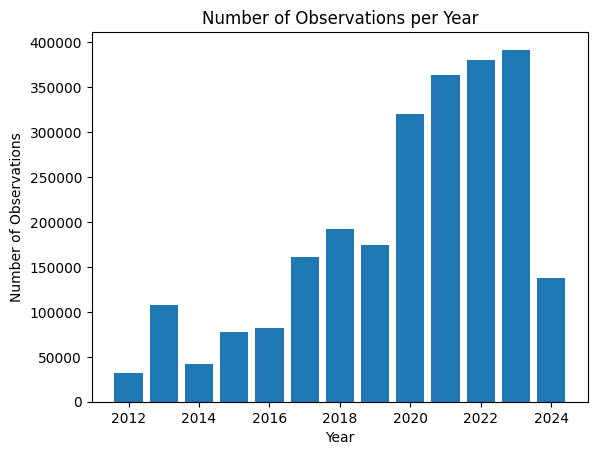

In [10]:
year_counts = df['year'].value_counts().sort_index()
years = list(range(2012, 2025))
counts = [year_counts.get(year, 0) for year in years]

plt.bar(years, counts, align='center', width=0.8)
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Year');

**Over 100,000 observations each year since 2017**

In [11]:
# Getting nodes reporting data each year
nodes_by_year = {}
for i in np.sort(df['year'].unique())[::-1]:
    nodes_by_year[i] = df[df['year'] == i]['node_id'].unique().tolist()
    print(f"Number of nodes in {i}: " + str(df[df['year'] == i]['node_id'].nunique()))

Number of nodes in 2024: 47
Number of nodes in 2023: 54
Number of nodes in 2022: 52
Number of nodes in 2021: 53
Number of nodes in 2020: 53
Number of nodes in 2019: 55
Number of nodes in 2018: 52
Number of nodes in 2017: 42
Number of nodes in 2016: 19
Number of nodes in 2015: 23
Number of nodes in 2014: 12
Number of nodes in 2013: 19
Number of nodes in 2012: 12


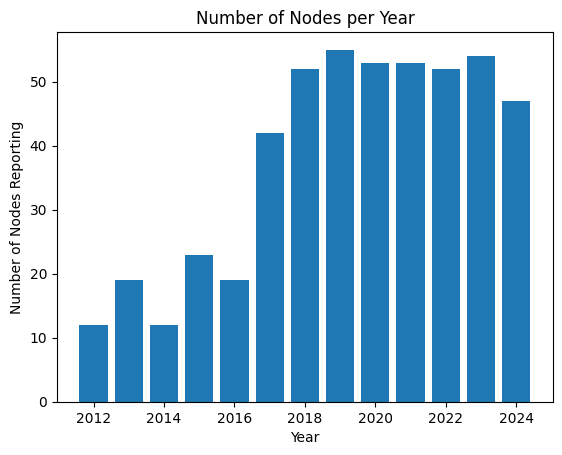

In [12]:
node_counts_per_year = df.groupby('year')['node_id'].nunique().sort_index()
years = list(range(2012, 2025))
counts = [node_counts_per_year.get(year, 0) for year in years]

plt.bar(years, counts, align='center', width=0.8)
plt.xlabel('Year')
plt.ylabel('Number of Nodes Reporting')
plt.title('Number of Nodes per Year');

In [13]:
# Comparing reporting nodes between years, for example 2021 to 2020 (both had 53 reporting nodes)
list(set(nodes_by_year[2021]).difference(nodes_by_year[2020]))

[3, 55, 46]

**50+ sensors for all years 2018 to 2023, not consistent sample of nodes each year**

In [14]:
# Investigating number of observations reported by each node
df['node_id'].value_counts()

node_id
48     79338
31     74727
33     69160
55     64109
45     61268
       ...  
318     3974
98      2438
27       781
1         48
12         1
Name: count, Length: 74, dtype: int64

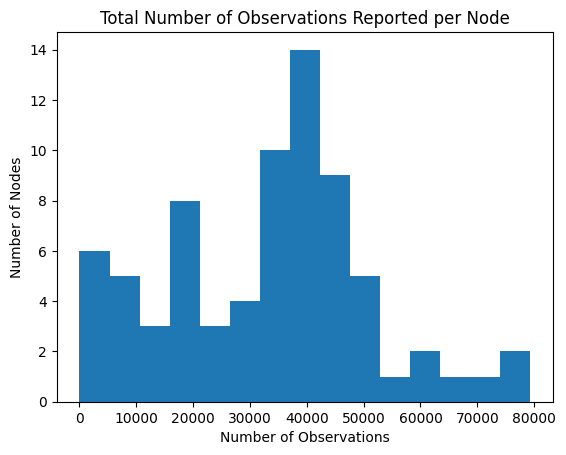

In [15]:
# Plotting total number of observations reported by each node
observations_per_node = df['node_id'].value_counts()
plt.hist(observations_per_node, bins=15)
plt.title('Total Number of Observations Reported per Node')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Nodes')

plt.show()

**Most sensors have reported around 40,000 measurements**

## Investigating invalid $\textnormal{CO}_2$ data

In [16]:
df['co2'].describe()

count    2.238627e+06
mean     6.518962e+01
std      6.229104e+02
min     -9.990000e+02
25%     -9.990000e+02
50%      4.164658e+02
75%      4.302184e+02
max      1.883965e+03
Name: co2, dtype: float64

In [17]:
# Filtering out invalid co2 data (-999)
co2_null = df[df['co2']<0]

In [18]:
print(f"Number of invalid measurements (reported as -999): {len(co2_null)}")

Number of invalid measurements (reported as -999): 570683


**Over 500,000 invalid measurements**

In [19]:
print(f"Number of nodes reporting invalid data: " + str(co2_null['node_id'].nunique()))

Number of nodes reporting invalid data: 74


**All sensors reported invalid data at some stage**

In [20]:
# Getting proportion of data reported by each sensor that is invalid
null_sensor_proportions = {}
for i in df['node_id'].unique():
    invalid = len(co2_null[co2_null['node_id'] == i]) / len(df[df['node_id'] == i])
    null_sensor_proportions[i] = invalid
    print(f"Proportion of data for node_id = {i} that is invalid: {invalid}")

Proportion of data for node_id = 280 that is invalid: 0.48421285051887836
Proportion of data for node_id = 1 that is invalid: 1.0
Proportion of data for node_id = 140 that is invalid: 0.657286833308387
Proportion of data for node_id = 19 that is invalid: 0.0887150466045273
Proportion of data for node_id = 46 that is invalid: 0.2548299283769855
Proportion of data for node_id = 28 that is invalid: 0.14294541709577754
Proportion of data for node_id = 58 that is invalid: 0.0028671966636257006
Proportion of data for node_id = 61 that is invalid: 0.27581844061363275
Proportion of data for node_id = 9 that is invalid: 0.14004024144869215
Proportion of data for node_id = 33 that is invalid: 0.45735974551764025
Proportion of data for node_id = 22 that is invalid: 0.052044277807534366
Proportion of data for node_id = 17 that is invalid: 0.008784456272447965
Proportion of data for node_id = 82 that is invalid: 0.15475354585030193
Proportion of data for node_id = 36 that is invalid: 0.001143807840

In [21]:
#Print node numbers where all data is missing
all_null = []
for key, value in null_sensor_proportions.items():
    if value == 1.0:
        all_null.append(key)

print(f"node_id where all data is invalid: {all_null}")

node_id where all data is invalid: [1, 12, 290, 318, 98]


**6 sensors that reported only invalid co2 measurements**

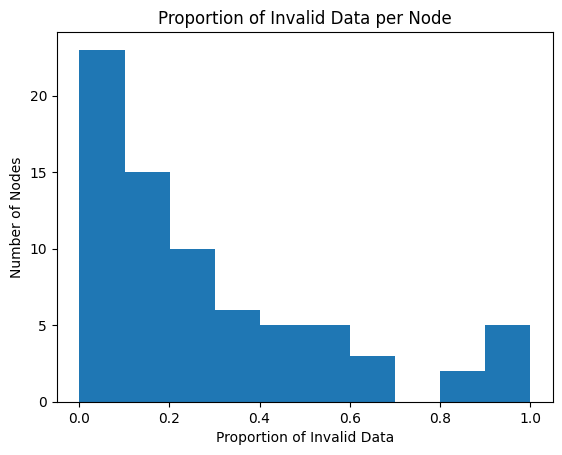

In [22]:
# Plotting proportions of reported data that is invalid
plt.hist(null_sensor_proportions.values())
plt.title('Proportion of Invalid Data per Node')
plt.xlabel('Proportion of Invalid Data')
plt.ylabel('Number of Nodes');

In [23]:
# Invalid CO2 observations per year
co2_null['year'].value_counts().sort_index(ascending=False)

year
2024     85534
2023    113910
2022     63144
2021     74256
2020     50282
2019     34422
2018     20155
2017     20888
2016      3800
2015      8988
2014     19737
2013     43178
2012     32389
Name: count, dtype: int64

**2023 had the most invalid measurements, followed by 2024 (so far). Likely due to more data being collected over time**

In [24]:
# Proportion of annual data that is invalid
for i in np.sort(df['year'].unique())[::-1]:
    print(f"Proportion of data that is invalid in {i}: {co2_null[co2_null['year']==i].shape[0]/df[df['year']==i].shape[0]}")

Proportion of data that is invalid in 2024: 0.6203060410472115
Proportion of data that is invalid in 2023: 0.2906467918115733
Proportion of data that is invalid in 2022: 0.16590297629056666
Proportion of data that is invalid in 2021: 0.20431151893684052
Proportion of data that is invalid in 2020: 0.15685968666745698
Proportion of data that is invalid in 2019: 0.19784805324688762
Proportion of data that is invalid in 2018: 0.10460511633459105
Proportion of data that is invalid in 2017: 0.12994494385517436
Proportion of data that is invalid in 2016: 0.0465577867898406
Proportion of data that is invalid in 2015: 0.11616605490358269
Proportion of data that is invalid in 2014: 0.46422523285351397
Proportion of data that is invalid in 2013: 0.40021133026842654
Proportion of data that is invalid in 2012: 1.0


**Proportion of missing data between 0.05 and 0.20 between 2015 and 2022. Increased rates of missing data for 2023 and 2024 so far**

**All 2012 data is invalid!**

In [25]:
# Number of invalid observations per day with invalid data
co2_null['date'].value_counts()

date
2024-04-02    865
2024-03-30    864
2024-03-29    864
2024-03-31    864
2024-04-01    864
             ... 
2015-10-21      1
2018-06-03      1
2015-10-11      1
2015-10-15      1
2017-01-25      1
Name: count, Length: 4114, dtype: int64

In [26]:
# Find number of missing days per year -- notice 365 days from 2018 to 2023
for i in np.sort(df['year'].unique())[::-1]:
    print(f"Number of days with missing data in {i}: {co2_null[co2_null['year']==i]['date'].nunique()}")

Number of days with missing data in 2024: 155
Number of days with missing data in 2023: 365
Number of days with missing data in 2022: 365
Number of days with missing data in 2021: 365
Number of days with missing data in 2020: 366
Number of days with missing data in 2019: 365
Number of days with missing data in 2018: 365
Number of days with missing data in 2017: 311
Number of days with missing data in 2016: 168
Number of days with missing data in 2015: 311
Number of days with missing data in 2014: 343
Number of days with missing data in 2013: 365
Number of days with missing data in 2012: 270


**Missing data reported every day in 2013, 2018, 2019, 2020, 2021, 2022, 2023**

In [27]:
print(f"Number of unique days in full dataset: {df['date'].nunique()}")
print(f"Number of unique days with invalid data: {co2_null['date'].nunique()}")

Number of unique days in full dataset: 4442
Number of unique days with invalid data: 4114


**4126 out of 4442 total days (over 90%) captured by data have invalid measurements**

In [28]:
# Investigating number of nodes and hours for each day with invalid data
co2_null = co2_null.copy()
co2_null.loc[:, 'hour'] = co2_null['timestamp'].dt.hour

aggregated = co2_null.groupby('date').agg({
    'node_id': 'nunique',
    'hour': 'nunique'
}).reset_index()

unique_dates = aggregated['date'].tolist()
invalid_nodes = aggregated['node_id'].tolist()
invalid_hours = aggregated['hour'].tolist()

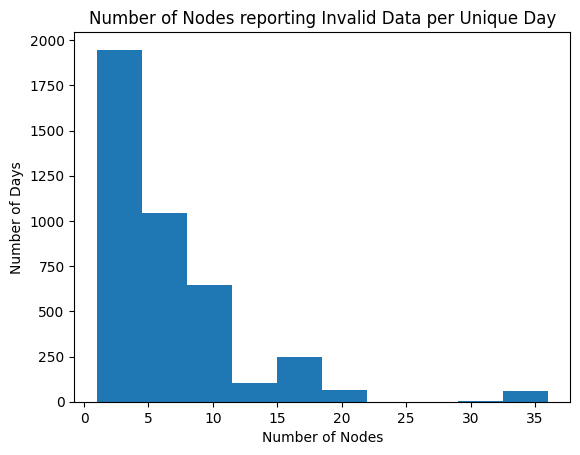

In [29]:
# Plotting number of nodes reporting invalid data for each day with invalid data
plt.hist(invalid_nodes)
plt.title('Number of Nodes reporting Invalid Data per Unique Day')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Days');

**Most days with invalid reported data have invalid data reported by 10 sensors or less**

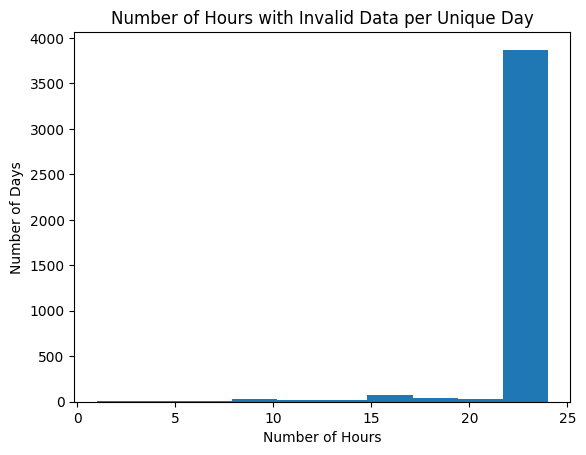

In [30]:
plt.hist(invalid_hours)
plt.title('Number of Hours with Invalid Data per Unique Day')
plt.xlabel('Number of Hours')
plt.ylabel('Number of Days');

**Most days with invalid data have data missing for each hour in the day**

In [31]:
# Saving invalid data by day as df
invalid_df = pd.DataFrame({
    'date': unique_dates,
    'invalid_nodes': invalid_nodes,
    'invalid_hours': invalid_hours
})

In [32]:
invalid_df.head()

,date,invalid_nodes,invalid_hours
0,2012-04-06,1,14
1,2012-04-07,1,24
2,2012-04-08,1,24
3,2012-04-09,1,24
4,2012-04-10,1,24


In [33]:
# Investigating raw numbers of invalid nodes per day
invalid_df['invalid_nodes'].value_counts().sort_index()

invalid_nodes
1     489
2     726
3     428
4     304
5     295
6     366
7     381
8     260
9     136
10    186
11     63
12     23
13     23
14     59
15    105
16     87
17     29
18     25
19     23
20     39
21      2
32      4
33     41
34     11
35      2
36      7
Name: count, dtype: int64

**Most days with invalid data had invalid data reported by between 1 and 10 sensors**

In [34]:
# Investigating raw numbers of missing hours per day
invalid_df['invalid_hours'].value_counts().sort_index()

invalid_hours
1        6
2        5
4        6
5        3
6        4
7        5
8       23
9        5
10       4
11       6
12      16
13       5
14      13
15      20
16      21
17      28
18      22
19      20
20      16
21      16
22      15
23      53
24    3802
Name: count, dtype: int64

**Most days with invalid data had data missing at all hours of the day**

## Investigating missing data for other features

In [35]:
# Filtering out invalid co2 measurements
valid_df = df[df['co2']>0]

In [36]:
print(f"Number of nodes in filtered dataframe: " + str(valid_df['node_id'].nunique()))
print(f"Number of observations in filtered dataframe: " + str(len(valid_df)))

Number of nodes in filtered dataframe: 67
Number of observations in filtered dataframe: 1667944


In [37]:
# Checking for missing data
valid_df.isna().sum()

node_id              0
timestamp            0
co2                  0
temp              3693
pressure          3696
rh                3694
year                 0
month                0
date                 0
node_name_long       0
lat                  0
lng                  0
dtype: int64

**NaN data for all three meteorological variables**

### Missing meteorological data

In [38]:
# Filtering dataframe to get only rows with missing meteorological data
meteo_null = valid_df[valid_df.isna().any(axis=1)]
meteo_null

,node_id,timestamp,co2,temp,pressure,rh,year,month,date,node_name_long,lat,lng
303534,82,2019-03-31 15:00:00,415.530784,NaN,NaN,NaN,2019,3,2019-03-31,Glen Cove Elementary School,38.075,-122.209
303538,82,2019-03-31 22:00:00,428.092239,NaN,NaN,NaN,2019,3,2019-03-31,Glen Cove Elementary School,38.075,-122.209
303540,82,2019-04-01 02:00:00,434.929742,NaN,NaN,NaN,2019,4,2019-04-01,Glen Cove Elementary School,38.075,-122.209
303544,82,2019-04-01 17:00:00,424.742378,NaN,NaN,NaN,2019,4,2019-04-01,Glen Cove Elementary School,38.075,-122.209
303545,82,2019-04-01 18:00:00,431.193919,NaN,NaN,NaN,2019,4,2019-04-01,Glen Cove Elementary School,38.075,-122.209
...,...,...,...,...,...,...,...,...,...,...,...,...
2185011,55,2017-08-06 18:00:00,442.944619,NaN,NaN,NaN,2017,8,2017-08-06,Chabot Space & Science Center,37.819,-122.181
2185013,55,2017-08-06 20:00:00,433.963183,NaN,NaN,NaN,2017,8,2017-08-06,Chabot Space & Science Center,37.819,-122.181
2185014,55,2017-08-06 21:00:00,431.144202,NaN,NaN,NaN,2017,8,2017-08-06,Chabot Space & Science Center,37.819,-122.181
2185015,55,2017-08-06 22:00:00,429.444301,NaN,NaN,NaN,2017,8,2017-08-06,Chabot Space & Science Center,37.819,-122.181


In [39]:
# Investigating missing meteorological data by node_id
meteo_null['node_id'].value_counts()

node_id
25    3189
78     107
62      59
82      58
64      50
41      36
54      34
49      28
35      23
63      23
56      18
8       17
7       15
80      11
52       9
65       6
55       5
31       4
14       3
16       1
11       1
Name: count, dtype: int64

**`node_id`=
25 had the most invalid meteorological measurements.**

In [40]:
# Number of missing meteorological observations per year
meteo_null['year'].value_counts().sort_index(ascending=False)

year
2023    1088
2022    2101
2019     282
2018     219
2017       6
2016       1
Name: count, dtype: int64

In [41]:
# Find number of missing days per year
for i in np.sort(meteo_null['year'].unique())[::-1]:
    print(f"Number of days with missing meteorological data in {i}: {meteo_null[meteo_null['year'] == i]['date'].nunique()}")

Number of days with missing meteorological data in 2023: 59
Number of days with missing meteorological data in 2022: 114
Number of days with missing meteorological data in 2019: 133
Number of days with missing meteorological data in 2018: 127
Number of days with missing meteorological data in 2017: 3
Number of days with missing meteorological data in 2016: 1


**Not every year has missing meteorological data, but 2019 had the most days with missing data, and 2022 had the most missing observations overall.**

In [42]:
# Dropping NaN temp/pressure/rh values
valid_df = valid_df.dropna()

In [43]:
print(f"Number of nodes in filtered dataframe: " + str(valid_df['node_id'].nunique()))
print(f"Number of observations in filtered dataframe: " + str(len(valid_df)))

Number of nodes in filtered dataframe: 67
Number of observations in filtered dataframe: 1664247


**After dropping invalid $\textnormal{CO}_2$ and meteorological data, we still have over 1.6 million observations**

In [44]:
# Investigating number of valid hourly observations per year
for i in np.sort(df['year'].unique())[::-1]:
    print(f"Number of observations in  {i}: {len(valid_df[valid_df['year'] == i])}")

Number of observations in  2024: 49930
Number of observations in  2023: 266498
Number of observations in  2022: 308704
Number of observations in  2021: 285572
Number of observations in  2020: 262680
Number of observations in  2019: 107983
Number of observations in  2018: 150127
Number of observations in  2017: 128006
Number of observations in  2016: 55569
Number of observations in  2015: 41446
Number of observations in  2014: 7732
Number of observations in  2013: 0
Number of observations in  2012: 0


In [45]:
# Investigating number of reporting nodes per year
for i in np.sort(df['year'].unique())[::-1]:
    print(f"Number of nodes in {i}: " + str(valid_df[valid_df['year'] == i]['node_id'].nunique()))

Number of nodes in 2024: 32
Number of nodes in 2023: 45
Number of nodes in 2022: 47
Number of nodes in 2021: 49
Number of nodes in 2020: 46
Number of nodes in 2019: 51
Number of nodes in 2018: 43
Number of nodes in 2017: 35
Number of nodes in 2016: 12
Number of nodes in 2015: 10
Number of nodes in 2014: 4
Number of nodes in 2013: 0
Number of nodes in 2012: 0


**We have no more valid data from 2012 and 2013**

## Exploring key features

In [46]:
# Viewing current data
valid_df

,node_id,timestamp,co2,temp,pressure,rh,year,month,date,node_name_long,lat,lng
21,280,2022-05-09 15:00:00,421.273468,19.688687,1007.304396,31.716438,2022,5,2022-05-09,Berkeley Way West,37.873,-122.268
22,280,2022-05-09 16:00:00,420.057025,20.073486,1007.117362,31.500970,2022,5,2022-05-09,Berkeley Way West,37.873,-122.268
23,280,2022-05-09 17:00:00,420.837519,19.733823,1007.090534,33.358016,2022,5,2022-05-09,Berkeley Way West,37.873,-122.268
24,280,2022-05-09 18:00:00,422.655886,18.912547,1007.157578,33.880530,2022,5,2022-05-09,Berkeley Way West,37.873,-122.268
25,280,2022-05-09 19:00:00,428.649511,15.884778,1007.274994,39.739975,2022,5,2022-05-09,Berkeley Way West,37.873,-122.268
...,...,...,...,...,...,...,...,...,...,...,...,...
2463599,51,2024-03-18 06:00:00,440.371434,11.841589,1005.303160,78.312330,2024,3,2024-03-18,El Sobrante,37.974,-122.275
2463600,51,2024-03-18 07:00:00,454.085831,11.326005,1005.627411,77.408000,2024,3,2024-03-18,El Sobrante,37.974,-122.275
2463601,51,2024-03-18 08:00:00,440.770690,12.280668,1006.036349,77.101930,2024,3,2024-03-18,El Sobrante,37.974,-122.275
2463602,51,2024-03-18 09:00:00,429.737452,14.730266,1006.339326,70.066189,2024,3,2024-03-18,El Sobrante,37.974,-122.275


### `node_id`

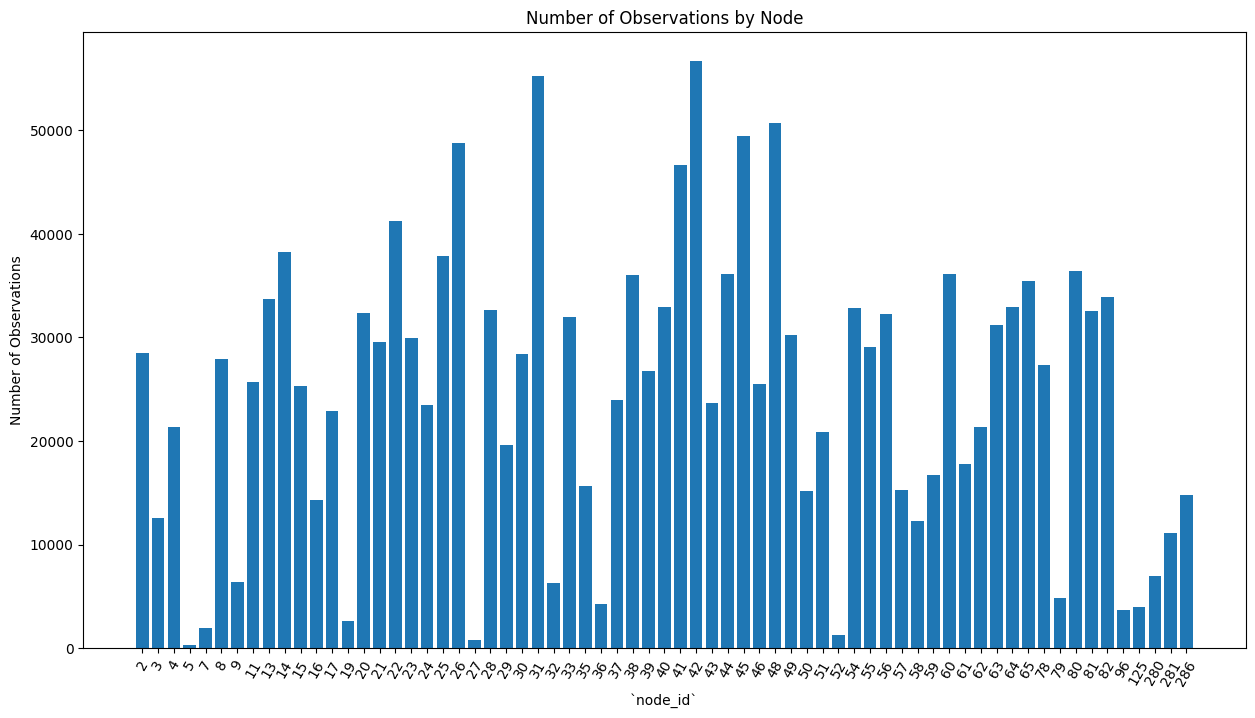

In [47]:
# Plotting number of valid observations reported by each node
plt.figure(figsize=(15, 8))

plt.bar(valid_df['node_id'].value_counts().sort_index().index.astype(str), 
        valid_df['node_id'].value_counts().sort_index().values)

plt.xticks(rotation=60)
plt.xlabel('`node_id`')
plt.ylabel('Number of Observations')
plt.title('Number of Observations by Node');

### `timestamp`

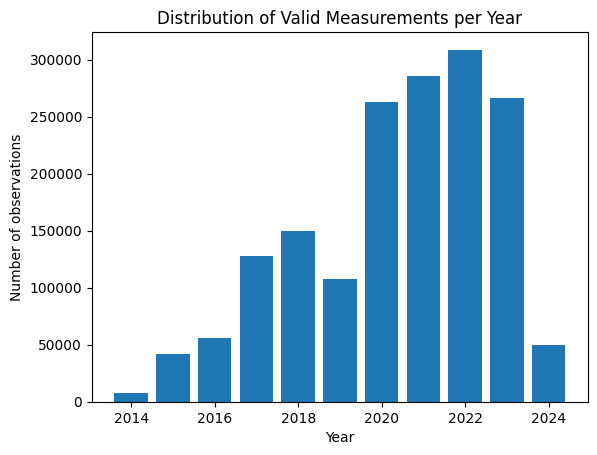

In [48]:
valid_year_counts = valid_df['year'].value_counts().sort_index()
valid_years = list(range(2014, 2025))
valid_counts = [year_counts.get(year, 0) for year in years]

plt.bar(valid_years, valid_year_counts, align='center', width=0.8)
plt.title('Distribution of Valid Measurements per Year')
plt.xlabel('Year')
plt.ylabel('Number of observations');

### `co2`

In [49]:
valid_df['co2'].describe().apply(lambda x: '{:.5f}'.format(x))

count    1664247.00000
mean         429.28840
std           26.81768
min            0.00858
25%          413.71344
50%          422.48244
75%          437.08945
max         1883.96549
Name: co2, dtype: object

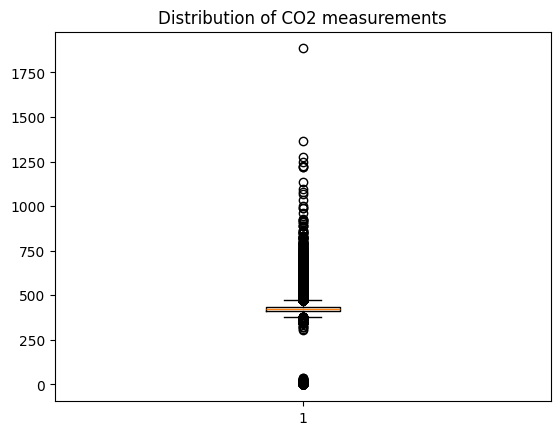

In [50]:
# Plotting boxplot distribution of co2 measurements
plt.boxplot(valid_df['co2'])
plt.title('Distribution of CO2 measurements');

In [51]:
# Investigating lower outliers
valid_df[valid_df['co2']<250]

,node_id,timestamp,co2,temp,pressure,rh,year,month,date,node_name_long,lat,lng
2059175,48,2022-08-05 11:00:00,17.625826,28.640238,1014.549589,37.415314,2022,8,2022-08-05,Exploratorium Bay,37.802,-122.397
2059176,48,2022-08-05 12:00:00,19.737726,26.243353,1014.462735,41.919745,2022,8,2022-08-05,Exploratorium Bay,37.802,-122.397
2059177,48,2022-08-05 13:00:00,21.234339,25.433904,1014.391011,44.423420,2022,8,2022-08-05,Exploratorium Bay,37.802,-122.397
2059178,48,2022-08-05 14:00:00,17.023805,27.028590,1014.269928,40.931860,2022,8,2022-08-05,Exploratorium Bay,37.802,-122.397
2059179,48,2022-08-05 15:00:00,12.929253,27.597078,1014.015609,39.509051,2022,8,2022-08-05,Exploratorium Bay,37.802,-122.397
...,...,...,...,...,...,...,...,...,...,...,...,...
2060964,48,2022-10-19 02:00:00,1.970282,20.594616,1017.301331,52.033935,2022,10,2022-10-19,Exploratorium Bay,37.802,-122.397
2061526,48,2022-11-11 11:00:00,2.628887,22.198093,1021.629807,38.868702,2022,11,2022-11-11,Exploratorium Bay,37.802,-122.397
2061692,48,2022-11-18 09:00:00,4.061385,21.534803,1019.688387,41.092927,2022,11,2022-11-18,Exploratorium Bay,37.802,-122.397
2061693,48,2022-11-18 10:00:00,7.853631,21.022468,1019.478879,42.417671,2022,11,2022-11-18,Exploratorium Bay,37.802,-122.397


In [52]:
valid_df[valid_df['co2']<300]['node_id'].unique()

array([48])

**489 `co2` observations reported by sensor 48 below 300ppm... valid?**

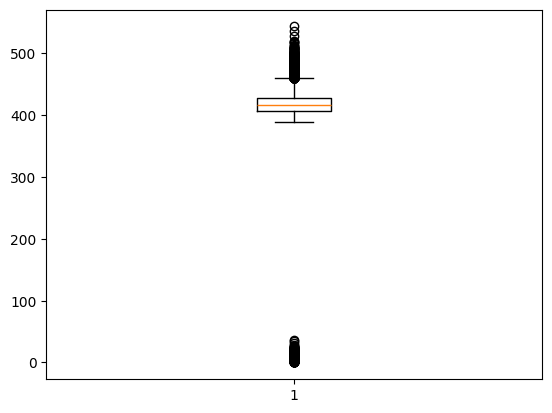

In [53]:
plt.boxplot(valid_df[valid_df['node_id']==48]['co2']);

In [54]:
valid_df[valid_df['co2']<300]['timestamp'].dt.date.unique()

array([datetime.date(2022, 8, 5), datetime.date(2022, 8, 6),
       datetime.date(2022, 8, 7), datetime.date(2022, 8, 8),
       datetime.date(2022, 8, 9), datetime.date(2022, 8, 10),
       datetime.date(2022, 8, 11), datetime.date(2022, 8, 12),
       datetime.date(2022, 8, 13), datetime.date(2022, 8, 14),
       datetime.date(2022, 8, 15), datetime.date(2022, 8, 16),
       datetime.date(2022, 8, 17), datetime.date(2022, 8, 18),
       datetime.date(2022, 8, 19), datetime.date(2022, 8, 20),
       datetime.date(2022, 8, 21), datetime.date(2022, 8, 22),
       datetime.date(2022, 8, 23), datetime.date(2022, 8, 24),
       datetime.date(2022, 8, 25), datetime.date(2022, 8, 26),
       datetime.date(2022, 8, 27), datetime.date(2022, 8, 28),
       datetime.date(2022, 8, 30), datetime.date(2022, 8, 31),
       datetime.date(2022, 9, 1), datetime.date(2022, 9, 2),
       datetime.date(2022, 9, 3), datetime.date(2022, 9, 4),
       datetime.date(2022, 9, 5), datetime.date(2022, 9, 6),
   

In [55]:
# Filtering out 489 unusually low CO2 observations
valid_df = valid_df[valid_df['co2']>250]

In [56]:
valid_df['co2'].describe().apply(lambda x: '{:.5f}'.format(x))

count    1663758.00000
mean         429.41149
std           25.84226
min          304.23970
25%          413.72159
50%          422.48805
75%          437.09648
max         1883.96549
Name: co2, dtype: object

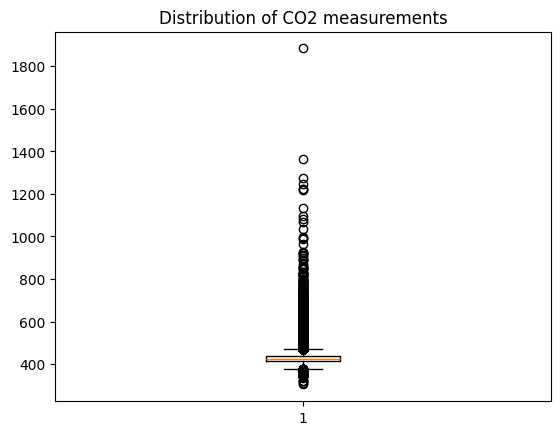

In [57]:
# Plotting boxplot distribution of co2 measurements
plt.boxplot(valid_df['co2'])
plt.title('Distribution of CO2 measurements');

**Still have unusually high measurements too...**

### `temp`

In [58]:
valid_df['temp'].describe().apply(lambda x: '{:.5f}'.format(x))

count    1663758.00000
mean          19.41809
std            8.76539
min          -40.10000
25%           14.60321
50%           18.20086
75%           24.17546
max           62.87295
Name: temp, dtype: object

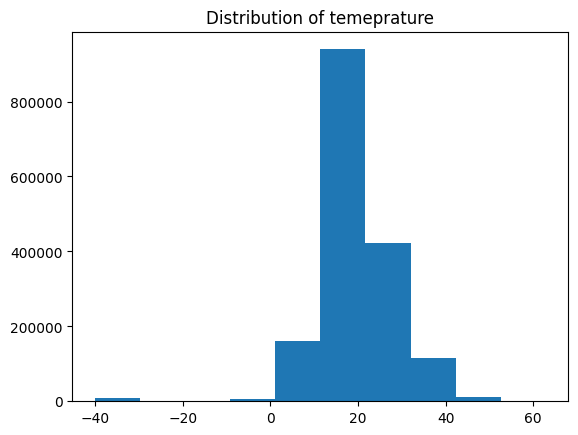

In [59]:
# Plotting distribution of temperature observations
plt.hist(valid_df['temp'])
plt.title('Distribution of temeprature');

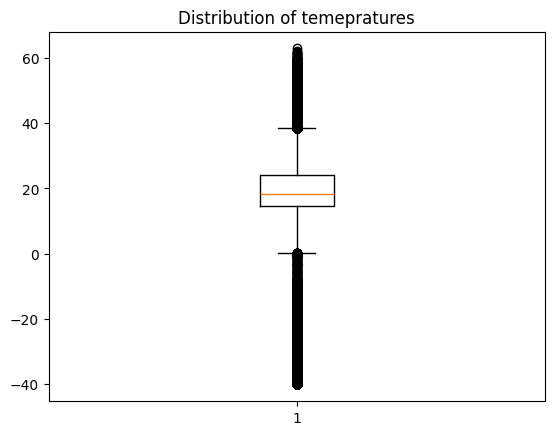

In [60]:
# Plotting boxplot distribution of temperature observations
plt.boxplot(valid_df['temp'])
plt.title('Distribution of temepratures');

In [61]:
# Investigating sub-zero temperature observations (unlikely in Bay Area)...
valid_df[valid_df['temp']<0]

,node_id,timestamp,co2,temp,pressure,rh,year,month,date,node_name_long,lat,lng
147974,61,2022-02-24 05:00:00,504.316999,-0.236001,1024.789511,79.441851,2022,2,2022-02-24,John W. Finney High School,38.133,-122.249
147975,61,2022-02-24 06:00:00,531.884708,-0.275863,1025.204067,79.244318,2022,2,2022-02-24,John W. Finney High School,38.133,-122.249
433580,30,2021-01-27 06:00:00,406.806419,-36.584370,1054.106450,43.168990,2021,1,2021-01-27,Sheldon Elementary School,37.967,-122.298
433588,30,2021-01-27 14:00:00,403.691385,-32.428810,1055.433080,34.692120,2021,1,2021-01-27,Sheldon Elementary School,37.967,-122.298
433591,30,2021-01-27 17:00:00,404.900511,-28.756340,1051.087560,37.575120,2021,1,2021-01-27,Sheldon Elementary School,37.967,-122.298
...,...,...,...,...,...,...,...,...,...,...,...,...
1978611,63,2022-02-23 06:00:00,519.607864,-0.117566,1018.008040,84.424899,2022,2,2022-02-23,Dan Mini Elementary School,38.150,-122.259
1978632,63,2022-02-24 03:00:00,542.650120,-0.641303,1024.625618,75.927856,2022,2,2022-02-24,Dan Mini Elementary School,38.150,-122.259
1978633,63,2022-02-24 04:00:00,536.870838,-1.146767,1025.084461,77.754841,2022,2,2022-02-24,Dan Mini Elementary School,38.150,-122.259
1978634,63,2022-02-24 05:00:00,527.931428,-1.361531,1025.556084,77.820315,2022,2,2022-02-24,Dan Mini Elementary School,38.150,-122.259


**10240 `temp` observations below 0°C... valid?**

In [62]:
# Getting months with sub-zero temperature measurements
valid_df[valid_df['temp']<0]['timestamp'].dt.month.value_counts().sort_index()

timestamp
1      752
2      681
3     1190
4     1436
5     1070
6      719
7      744
8      744
9      699
10     740
11     721
12     744
Name: count, dtype: int64

In [63]:
# Getting node_id's reporting sub-zero temperatures
valid_df[valid_df['temp']<0]['node_id'].unique()

array([61, 30, 31, 63])

### `pressure`

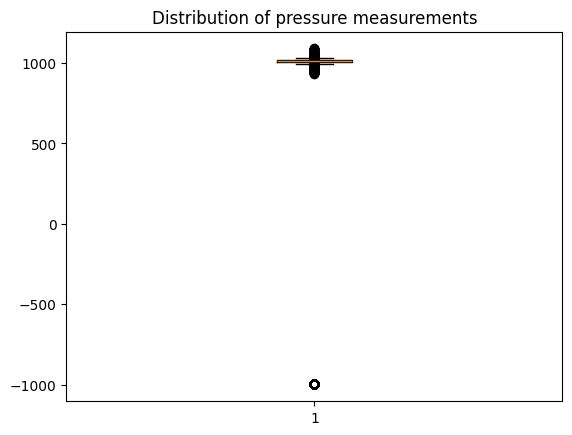

In [64]:
# Plotting distribution of pressure adta
plt.boxplot(valid_df['pressure'])
plt.title('Distribution of pressure measurements');

In [65]:
# Investigating low outliers
valid_df[valid_df['pressure']<500]['pressure']

1214684   -999.0
1214685   -999.0
1214686   -999.0
1214687   -999.0
1214688   -999.0
           ...  
2200111   -999.0
2200112   -999.0
2200113   -999.0
2200114   -999.0
2200115   -999.0
Name: pressure, Length: 951, dtype: float64

**951 `-999` measurements for pressure. More invalid data**

In [66]:
#Confirming that all remaining invalid measurements are from pressure. 951 rows = confirmed
valid_df[valid_df.isin([-999]).any(axis=1)]

,node_id,timestamp,co2,temp,pressure,rh,year,month,date,node_name_long,lat,lng
1214684,49,2018-09-02 23:00:00,404.775881,25.24,-999.0,72.01758,2018,9,2018-09-02,Burckhalter Elementary,37.775,-122.167
1214685,49,2018-09-03 00:00:00,402.775113,25.24,-999.0,72.01758,2018,9,2018-09-03,Burckhalter Elementary,37.775,-122.167
1214686,49,2018-09-03 01:00:00,401.470765,25.24,-999.0,72.01758,2018,9,2018-09-03,Burckhalter Elementary,37.775,-122.167
1214687,49,2018-09-03 02:00:00,400.899933,25.24,-999.0,72.01758,2018,9,2018-09-03,Burckhalter Elementary,37.775,-122.167
1214688,49,2018-09-03 03:00:00,401.664186,25.24,-999.0,72.01758,2018,9,2018-09-03,Burckhalter Elementary,37.775,-122.167
...,...,...,...,...,...,...,...,...,...,...,...,...
2200111,55,2019-08-19 13:00:00,401.376959,22.92,-999.0,70.92285,2019,8,2019-08-19,Chabot Space & Science Center,37.819,-122.181
2200112,55,2019-08-19 14:00:00,401.906734,22.92,-999.0,70.92285,2019,8,2019-08-19,Chabot Space & Science Center,37.819,-122.181
2200113,55,2019-08-19 15:00:00,402.720681,22.92,-999.0,70.92285,2019,8,2019-08-19,Chabot Space & Science Center,37.819,-122.181
2200114,55,2019-08-19 16:00:00,404.686951,22.92,-999.0,70.92285,2019,8,2019-08-19,Chabot Space & Science Center,37.819,-122.181


In [67]:
# Dropping all -999 values
valid_df = valid_df[valid_df['pressure']>500].copy()

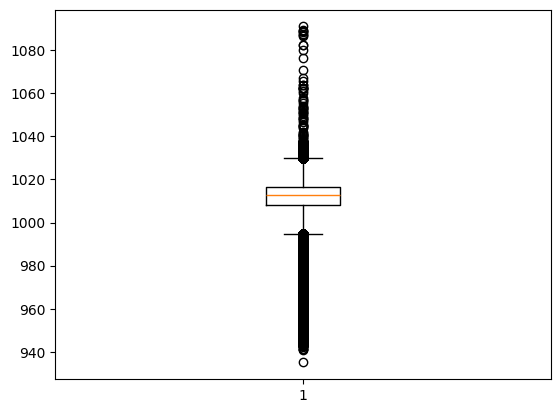

In [68]:
# Plotting distribution of pressures after dropping -999
plt.boxplot(valid_df['pressure']);

**Distribution of pressure appears fair after dropping invalid measurements**

### `rh`

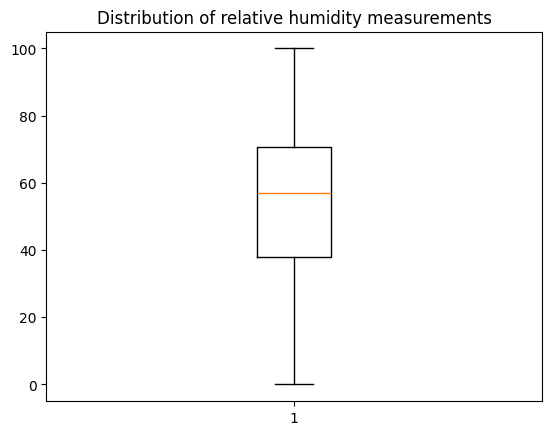

In [69]:
# Plotting distribution of relative humidity
plt.boxplot(valid_df['rh'])
plt.title('Distribution of relative humidity measurements');

**0-100 seems an appropriate range of values for relative humidity**

In [70]:
print(f"Number of nodes in filtered dataframe: " + str(valid_df['node_id'].nunique()))
print(f"Number of observations in filtered dataframe: " + str(len(valid_df)))

Number of nodes in filtered dataframe: 67
Number of observations in filtered dataframe: 1662807


## Getting Daily Averages

In [71]:
mean_columns = valid_df.drop(columns=['node_name_long'])

grouped = mean_columns.groupby(['node_id', 'date'])

# Implementing condition of at least 18 valid observations per day (Larkin et al. and Lee et al.)
valid_groups = grouped.filter(lambda x: len(x) >= 18)

daily_avg = valid_groups.groupby(['node_id', 'date']).mean()

In [72]:
daily_avg.reset_index(inplace=True)
daily_avg

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng
0,2,2015-02-03,2015-02-03 11:30:00,436.042374,16.980245,1015.074005,63.821168,2015.0,2.0,38.289,-122.503
1,2,2015-02-04,2015-02-04 11:30:00,438.478472,15.822596,1013.333705,68.045385,2015.0,2.0,38.289,-122.503
2,2,2015-03-14,2015-03-14 11:30:00,450.383408,22.581634,1013.953940,54.688219,2015.0,3.0,38.289,-122.503
3,2,2015-03-15,2015-03-15 11:30:00,425.889624,19.821010,1013.194940,49.344820,2015.0,3.0,38.289,-122.503
4,2,2015-03-16,2015-03-16 11:30:00,439.721886,18.596646,1013.002304,62.354269,2015.0,3.0,38.289,-122.503
...,...,...,...,...,...,...,...,...,...,...,...
67039,286,2024-03-22,2024-03-22 11:30:00,434.502675,20.390149,1014.145432,49.324725,2024.0,3.0,37.847,-122.280
67040,286,2024-03-23,2024-03-23 11:30:00,425.356008,18.448980,1009.636745,51.039510,2024.0,3.0,37.847,-122.280
67041,286,2024-03-24,2024-03-24 11:30:00,421.349008,20.199887,1010.013281,42.642338,2024.0,3.0,37.847,-122.280
67042,286,2024-03-25,2024-03-25 11:30:00,423.765209,20.338516,1014.235041,42.538865,2024.0,3.0,37.847,-122.280


In [73]:
print(f"Number of obersvations in daily average dataframe: {len(daily_avg)}")

Number of obersvations in daily average dataframe: 67044


In [74]:
print(f"Number of nodes in daily average dataframe: {daily_avg['node_id'].nunique()}")

Number of nodes in daily average dataframe: 65


### Eliminating COVID-19 years

In [75]:
daily_avg['date'] = pd.to_datetime(daily_avg['date'])
daily_avg = daily_avg[(daily_avg['date'].dt.year != 2020) & (daily_avg['date'].dt.year != 2021)]

In [76]:
daily_avg

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng
0,2,2015-02-03,2015-02-03 11:30:00,436.042374,16.980245,1015.074005,63.821168,2015.0,2.0,38.289,-122.503
1,2,2015-02-04,2015-02-04 11:30:00,438.478472,15.822596,1013.333705,68.045385,2015.0,2.0,38.289,-122.503
2,2,2015-03-14,2015-03-14 11:30:00,450.383408,22.581634,1013.953940,54.688219,2015.0,3.0,38.289,-122.503
3,2,2015-03-15,2015-03-15 11:30:00,425.889624,19.821010,1013.194940,49.344820,2015.0,3.0,38.289,-122.503
4,2,2015-03-16,2015-03-16 11:30:00,439.721886,18.596646,1013.002304,62.354269,2015.0,3.0,38.289,-122.503
...,...,...,...,...,...,...,...,...,...,...,...
67039,286,2024-03-22,2024-03-22 11:30:00,434.502675,20.390149,1014.145432,49.324725,2024.0,3.0,37.847,-122.280
67040,286,2024-03-23,2024-03-23 11:30:00,425.356008,18.448980,1009.636745,51.039510,2024.0,3.0,37.847,-122.280
67041,286,2024-03-24,2024-03-24 11:30:00,421.349008,20.199887,1010.013281,42.642338,2024.0,3.0,37.847,-122.280
67042,286,2024-03-25,2024-03-25 11:30:00,423.765209,20.338516,1014.235041,42.538865,2024.0,3.0,37.847,-122.280


### Investigating variable distributions

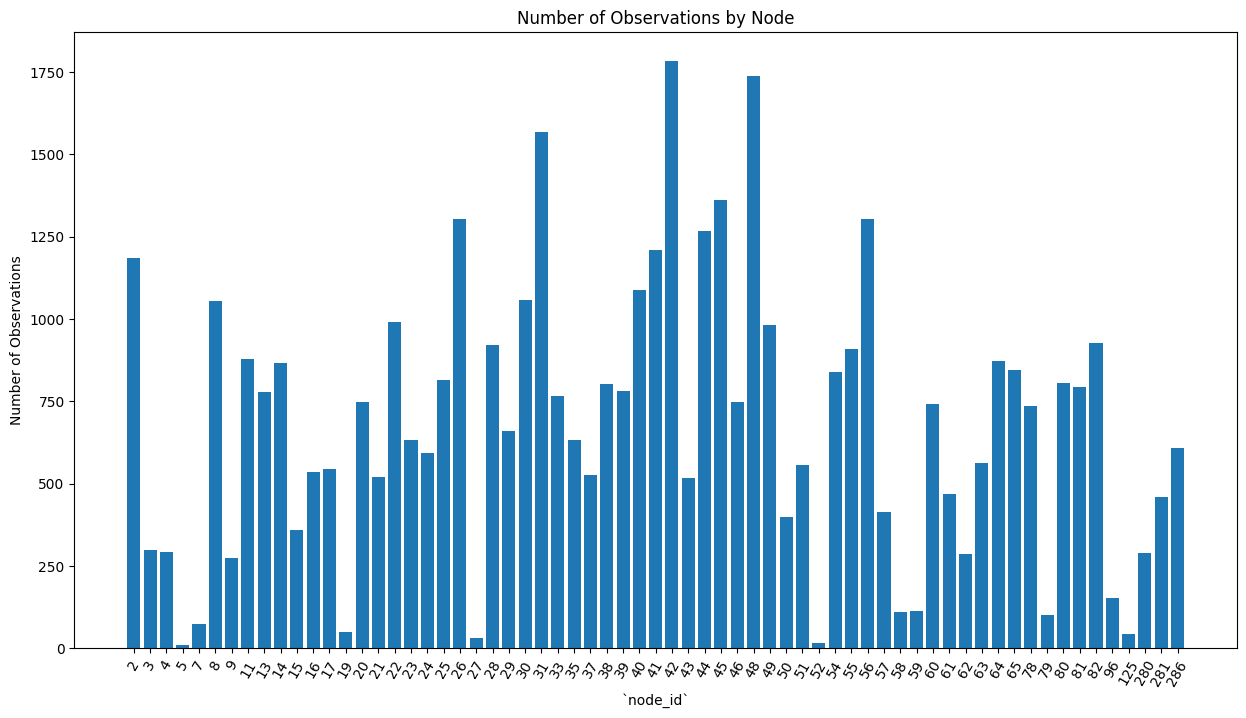

In [77]:
# Plotting number of valid observations reported by each node
plt.figure(figsize=(15, 8))

plt.bar(daily_avg['node_id'].value_counts().sort_index().index.astype(str), 
        daily_avg['node_id'].value_counts().sort_index().values)

plt.xticks(rotation=60)
plt.xlabel('`node_id`')
plt.ylabel('Number of Observations')
plt.title('Number of Observations by Node');

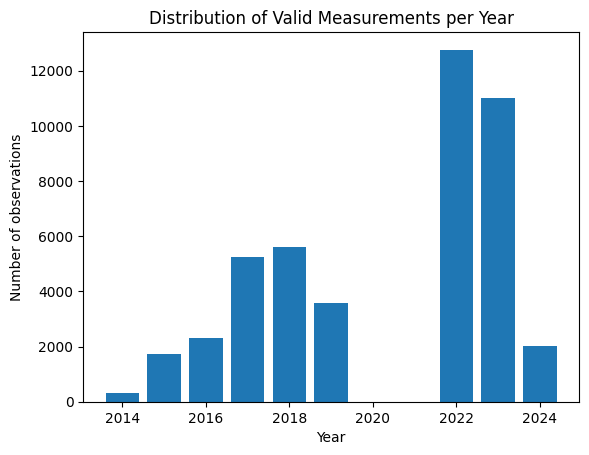

In [78]:
daily_avg = daily_avg.copy()
daily_avg['year'] = daily_avg['date'].dt.year
daily_avg_year_counts = daily_avg['year'].value_counts().sort_index()

daily_avg_years = daily_avg_year_counts.index.tolist()
daily_avg_counts = daily_avg_year_counts.values.tolist()

plt.bar(daily_avg_years, daily_avg_counts, align='center', width=0.8)
plt.title('Distribution of Valid Measurements per Year')
plt.xlabel('Year')
plt.ylabel('Number of observations');

In [79]:
daily_avg = daily_avg.copy()
daily_avg['month'] = daily_avg['date'].dt.month

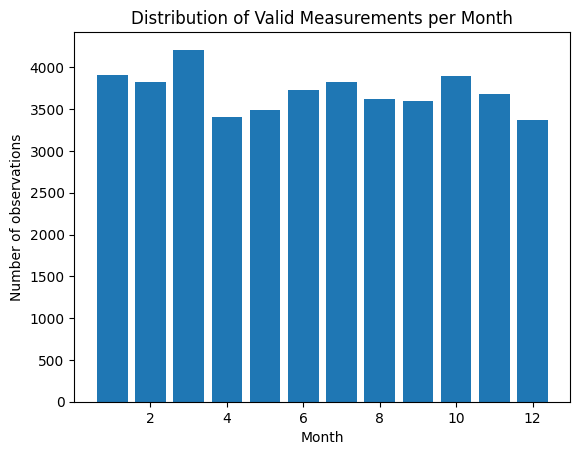

In [80]:
daily_avg_month_counts = daily_avg['month'].value_counts().sort_index()

daily_avg_months = daily_avg_month_counts.index.tolist()
daily_avg_month_counts = daily_avg_month_counts.values.tolist()

plt.bar(daily_avg_months, daily_avg_month_counts, align='center', width=0.8)
plt.title('Distribution of Valid Measurements per Month')
plt.xlabel('Month')
plt.ylabel('Number of observations');

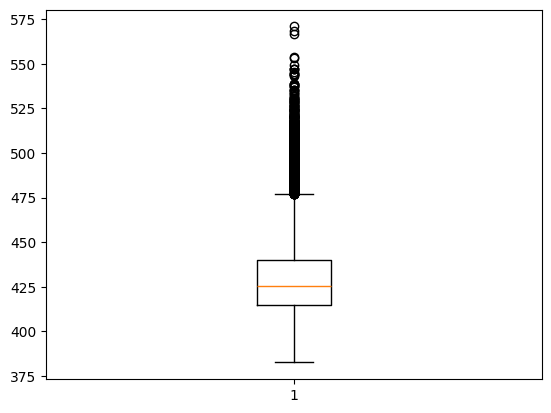

In [81]:
plt.boxplot(daily_avg['co2']);

In [82]:
daily_avg['co2'].describe()

count    44578.000000
mean       429.617009
std         21.153709
min        382.577957
25%        414.939339
50%        425.672094
75%        439.854568
max        570.910829
Name: co2, dtype: float64

In [83]:
daily_avg

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng
0,2,2015-02-03,2015-02-03 11:30:00,436.042374,16.980245,1015.074005,63.821168,2015,2,38.289,-122.503
1,2,2015-02-04,2015-02-04 11:30:00,438.478472,15.822596,1013.333705,68.045385,2015,2,38.289,-122.503
2,2,2015-03-14,2015-03-14 11:30:00,450.383408,22.581634,1013.953940,54.688219,2015,3,38.289,-122.503
3,2,2015-03-15,2015-03-15 11:30:00,425.889624,19.821010,1013.194940,49.344820,2015,3,38.289,-122.503
4,2,2015-03-16,2015-03-16 11:30:00,439.721886,18.596646,1013.002304,62.354269,2015,3,38.289,-122.503
...,...,...,...,...,...,...,...,...,...,...,...
67039,286,2024-03-22,2024-03-22 11:30:00,434.502675,20.390149,1014.145432,49.324725,2024,3,37.847,-122.280
67040,286,2024-03-23,2024-03-23 11:30:00,425.356008,18.448980,1009.636745,51.039510,2024,3,37.847,-122.280
67041,286,2024-03-24,2024-03-24 11:30:00,421.349008,20.199887,1010.013281,42.642338,2024,3,37.847,-122.280
67042,286,2024-03-25,2024-03-25 11:30:00,423.765209,20.338516,1014.235041,42.538865,2024,3,37.847,-122.280


In [84]:
daily_avg.groupby('node_id')['co2'].agg(['mean', 'std']).sort_values('std', ascending=False)

,mean,std
node_id,,
42,431.532384,33.145392
286,440.067461,30.120881
63,436.268608,27.391133
38,440.667192,26.670544
8,424.067888,25.921852
...,...,...
56,413.454766,10.831434
7,413.858064,9.736213
55,417.327253,8.348544


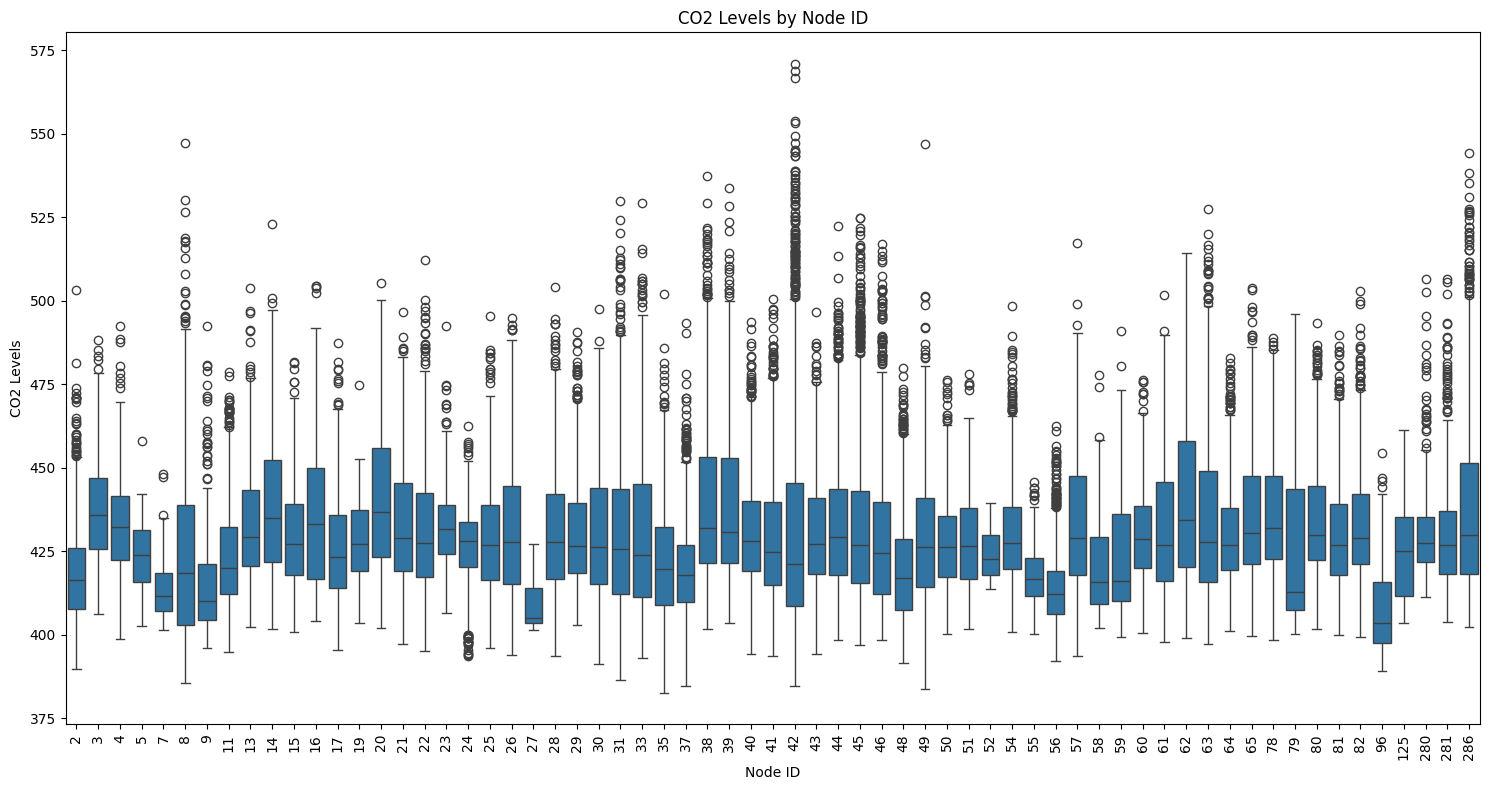

In [85]:
plt.figure(figsize=(15, 8))

sns.boxplot(x='node_id', y='co2', data=daily_avg)

plt.title('CO2 Concentration Distribution by node_id')
plt.xlabel('Node ID')
plt.ylabel('CO2 Concentration (ppm)');

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Temperature

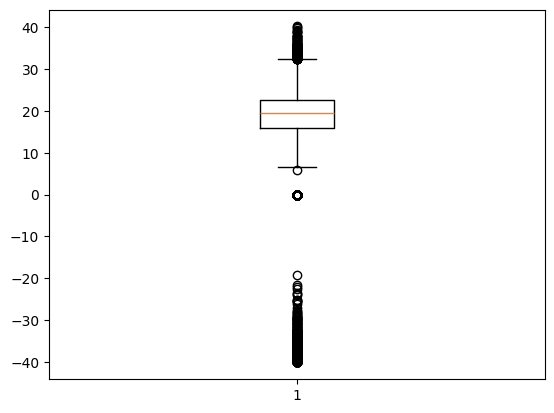

In [86]:
plt.boxplot(daily_avg['temp']);

In [87]:
daily_avg[daily_avg['temp']<0]['node_id'].unique()

array([31])

**Unusually low temperatures for Bay Area. Observations seem invalid.**

In [88]:
daily_avg = daily_avg[daily_avg['temp']>0]
#daily_avg.reset_index(inplace=True)
#daily_avg.drop(columns=['index'], inplace=True)

In [89]:
daily_avg['temp'].describe()

count    43902.000000
mean        19.489949
std          4.547434
min          5.978137
25%         16.109920
50%         19.500515
75%         22.561483
max         40.141816
Name: temp, dtype: float64

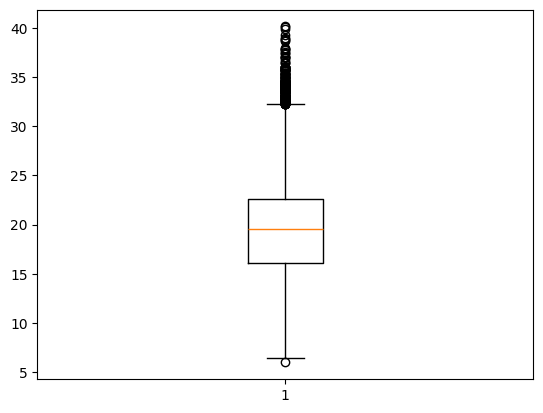

In [90]:
plt.boxplot(daily_avg['temp']);

### Pressure

In [91]:
daily_avg['pressure'].describe()

count    43902.000000
mean      1010.722175
std         10.667953
min        943.795824
25%       1007.949873
50%       1012.582160
75%       1016.629985
max       1040.994989
Name: pressure, dtype: float64

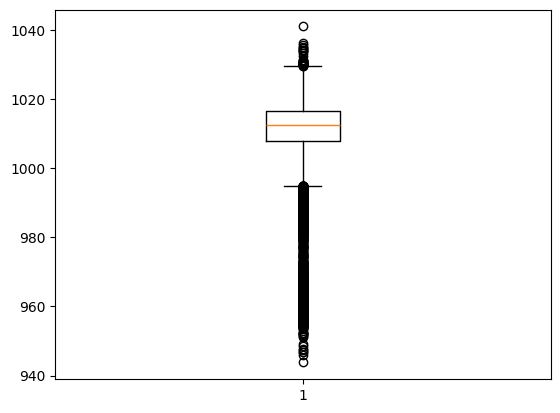

In [92]:
plt.boxplot(daily_avg['pressure']);

### Relative Humidity

In [93]:
daily_avg['rh'].describe()

count    43902.000000
mean        55.517782
std         12.892950
min          8.995339
25%         47.588916
50%         55.332064
75%         62.890068
max        100.000000
Name: rh, dtype: float64

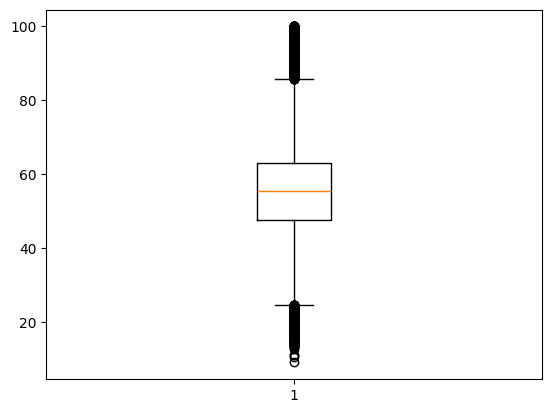

In [94]:
plt.boxplot(daily_avg['rh']);

In [95]:
daily_avg['rh'].describe()

count    43902.000000
mean        55.517782
std         12.892950
min          8.995339
25%         47.588916
50%         55.332064
75%         62.890068
max        100.000000
Name: rh, dtype: float64

In [96]:
print(f"Number of observations in daily average dataframe: {len(daily_avg)}")
print(f"Number of nodes in daily average dataframe: {daily_avg['node_id'].nunique()}")

Number of observations in daily average dataframe: 43902
Number of nodes in daily average dataframe: 65


In [97]:
# # Merging valid co2 data with node location data
daily_avg_df = pd.merge(daily_avg, bay_area_nodes[['id', 'node_name_long']], left_on='node_id', right_on='id', how='left').drop(columns=['id'])

In [98]:
# # Checking for missing data
daily_avg_df.isna().sum()

node_id           0
date              0
timestamp         0
co2               0
temp              0
pressure          0
rh                0
year              0
month             0
lat               0
lng               0
node_name_long    0
dtype: int64

In [99]:
daily_avg_df['node_id']

0          2
1          2
2          2
3          2
4          2
        ... 
43897    286
43898    286
43899    286
43900    286
43901    286
Name: node_id, Length: 43902, dtype: int64

In [100]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'daily_avg_BEACO2N.csv'
daily_avg_df.to_csv(path, index=False)
print(f"Data saved to {path}")

Data saved to /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/daily_avg_BEACO2N.csv


## Observations from the same day?

In [101]:
day_counts = daily_avg_df['date'].value_counts()

In [102]:
day_counts

date
2023-03-04    41
2023-03-03    41
2022-07-29    40
2022-07-28    40
2022-08-02    40
              ..
2024-04-17     1
2024-04-18     1
2024-04-19     1
2024-04-20     1
2024-05-27     1
Name: count, Length: 2842, dtype: int64

In [103]:
days_over_30 = day_counts[day_counts > 30].index

In [104]:
days_over_30_df = daily_avg_df[daily_avg_df['date'].isin(days_over_30)]

In [105]:
len(days_over_30_df)

18269

In [106]:
nodes_days_over_30 = daily_avg_df[daily_avg_df['date'].isin(days_over_30)]['node_id'].value_counts()

In [107]:
nodes_over_200_days_over_30 = nodes_days_over_30[nodes_days_over_30 > 200].index

In [108]:
balanced_daily_avg = days_over_30_df[days_over_30_df['node_id'].isin(nodes_over_200_days_over_30)]

In [109]:
balanced_daily_avg

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng,node_name_long
1539,4,2022-01-01,2022-01-01 11:30:00.000000000,444.400204,7.547035,999.754739,60.628520,2022,1,37.831,-122.213,Montclair Elementary School
1540,4,2022-01-02,2022-01-02 11:30:00.000000000,453.541155,8.937224,1001.820275,63.048644,2022,1,37.831,-122.213,Montclair Elementary School
1541,4,2022-01-03,2022-01-03 11:30:00.000000000,441.211655,10.741178,1000.370385,76.591252,2022,1,37.831,-122.213,Montclair Elementary School
1542,4,2022-01-04,2022-01-04 11:30:00.000000000,433.777005,13.741635,1003.960120,80.556825,2022,1,37.831,-122.213,Montclair Elementary School
1543,4,2022-01-05,2022-01-05 11:30:00.000000000,436.049086,14.247229,1002.731049,77.232257,2022,1,37.831,-122.213,Montclair Elementary School
...,...,...,...,...,...,...,...,...,...,...,...,...
43738,286,2023-10-08,2023-10-08 11:30:00.000000000,423.624269,24.253212,1010.376829,46.244989,2023,10,37.847,-122.280,Paradise Park
43739,286,2023-10-09,2023-10-09 11:30:00.000000000,416.561727,24.336228,1009.992955,46.518173,2023,10,37.847,-122.280,Paradise Park
43740,286,2023-10-10,2023-10-10 11:15:39.130434816,415.588174,24.621320,1008.725354,48.531213,2023,10,37.847,-122.280,Paradise Park
43741,286,2023-10-11,2023-10-11 11:30:00.000000000,420.917376,24.556401,1009.965181,38.998069,2023,10,37.847,-122.280,Paradise Park


In [110]:
len(balanced_daily_avg)

17389

In [111]:
balanced_daily_avg['node_id'].nunique()

42

In [112]:
balanced_daily_avg['node_id'].value_counts()

node_id
44     534
54     534
81     534
22     534
40     534
26     533
14     532
82     532
65     530
80     530
60     530
38     529
41     511
13     489
45     489
39     485
78     461
46     460
64     460
23     457
20     454
63     399
31     391
43     390
61     387
30     386
28     384
21     361
57     353
281    347
286    339
51     336
42     323
55     295
49     291
17     287
24     273
16     271
25     265
4      232
280    215
15     212
Name: count, dtype: int64

In [113]:
balanced_daily_avg['date'].value_counts()

date
2022-07-29    39
2022-07-31    39
2022-07-28    39
2022-07-30    39
2022-08-01    39
              ..
2023-07-07    27
2023-06-26    27
2023-06-25    27
2023-06-06    27
2023-10-12    27
Name: count, Length: 534, dtype: int64

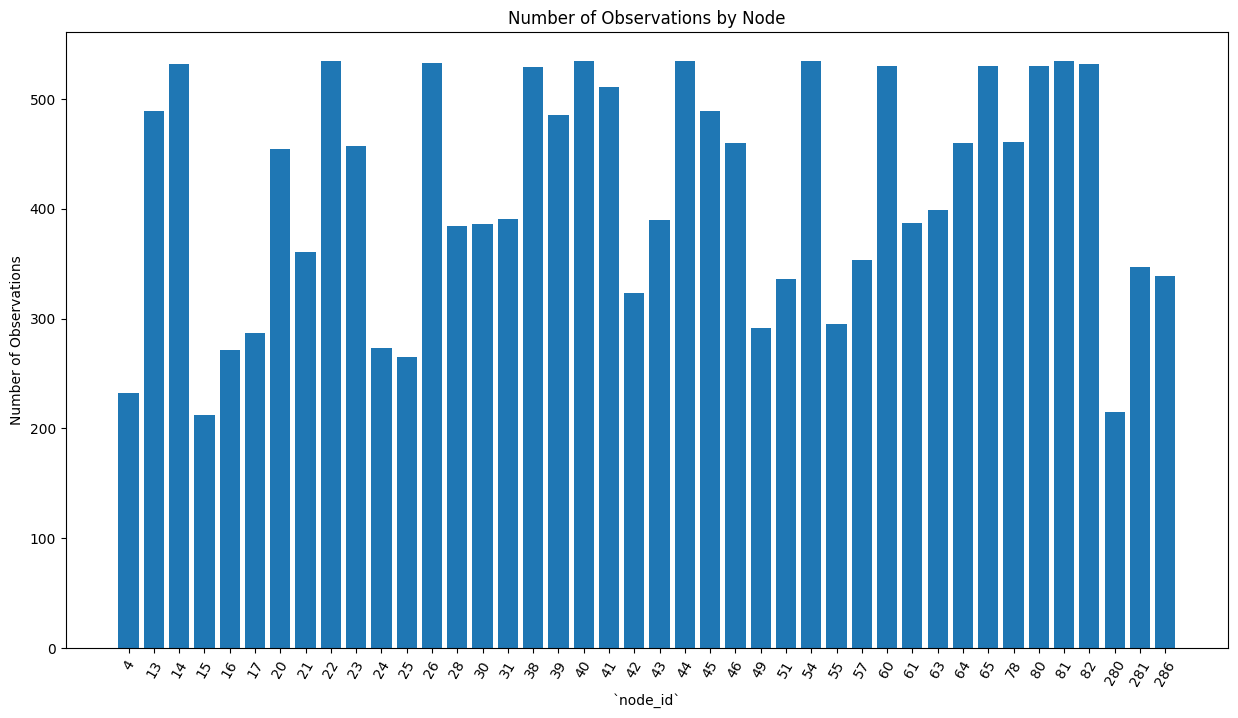

In [114]:
# Plotting number of valid observations reported by each node
plt.figure(figsize=(15, 8))

plt.bar(balanced_daily_avg['node_id'].value_counts().sort_index().index.astype(str), 
        balanced_daily_avg['node_id'].value_counts().sort_index().values)

plt.xticks(rotation=60)
plt.xlabel('`node_id`')
plt.ylabel('Number of Observations')
plt.title('Number of Observations by Node');

In [115]:
balanced_daily_avg['node_id'].nunique()

42

In [116]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'balanced_daily_avg_BEACO2N.csv'
balanced_daily_avg.to_csv(path, index=True)
print(f"Data saved to {path}")

Data saved to /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/balanced_daily_avg_BEACO2N.csv


## Test Nodes

In [117]:
# test_nodes = daily_avg_df[daily_avg_df['node_id'].isin(balanced_daily_avg['node_id'].unique()) == False]
# test_node_locations = test_nodes.drop_duplicates(subset=['node_id'])

In [118]:
#node_locations = df.drop_duplicates(subset=['node_id'])[['node_id', 'node_name_long', 'lat', 'lng']].sort_values('node_id').reset_index().drop(columns='index')
valid_node_locations = daily_avg.drop_duplicates(subset=['node_id'])[['node_id', 'lat', 'lng']].sort_values('node_id')#drop(columns='index')
valid_node_locations

,node_id,lat,lng
0,2,38.289,-122.503
1185,3,37.824,-122.233
1692,4,37.831,-122.213
2559,5,37.796,-122.279
2567,7,37.798,-122.161
...,...,...,...
65382,96,37.617,-122.069
65533,125,37.772,-122.392
65688,280,37.873,-122.268
65976,281,37.876,-122.267


In [119]:
valid_nodes = valid_node_locations['node_id'].unique()
balanced_data_nodes = balanced_daily_avg['node_id'].unique()
remaining_nodes = np.setdiff1d(valid_nodes, balanced_data_nodes)

In [120]:
all_node_locations = df.drop_duplicates(subset=['node_id'])[['node_id', 'node_name_long', 'lat', 'lng']].sort_values('node_id')
all_nodes = all_node_locations['node_id'].unique()
invalid_nodes = np.setdiff1d(all_nodes, valid_nodes)

In [121]:
node_labels = {'remaining valid node': remaining_nodes,
               'training node': balanced_data_nodes,
               'invalid node': invalid_nodes}

node_to_label = {node_id: label for label, node_ids in node_labels.items() for node_id in node_ids}

all_node_locations['label'] = all_node_locations['node_id'].map(node_to_label)

In [122]:
color_map = {
    'remaining valid node': 'red',
    'training node': 'blue',
    'invalid node': 'grey'
}

map_center = [37.955, -122.3]
nodes_map = folium.Map(location=map_center, zoom_start=10)

for _, row in all_node_locations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=5,
        color=color_map.get(row['label'], 'black'),
        fill=False,
        fill_color=color_map.get(row['label'], 'black'),
        fill_opacity=0.5,
        popup=row['node_id']
    ).add_to(nodes_map)

legend_html = '''
    <div style="position: fixed; 
                bottom: 10px; left: 60px; width: 200px; height: auto; 
                border:2px solid grey; background-color:white;
                z-index:9999; font-size:14px; padding:10px;
                box-shadow: 2px 2px 6px rgba(0,0,0,0.5);
                ">
    &nbsp; <b>Legend</b><br>
    &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; Remaining valid node<br>
    &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Training node<br>
    &nbsp; <i class="fa fa-circle" style="color:grey"></i>&nbsp; Invalid node<br>
    </div>
'''

# Add legend to the map
folium.Marker(
    location=[all_node_locations['lat'].mean(), all_node_locations['lng'].mean()],
    icon=folium.DivIcon(html=legend_html)
).add_to(nodes_map)

# Display the map
nodes_map

In [123]:
central_test_nodes = [19, 33, 50, 59, 62] # central nodes
fringe_test_nodes = [2, 5, 7, 9, 27, 48, 96] # fringe nodes
imbalanced_nodes = np.setdiff1d(remaining_nodes, central_test_nodes + fringe_test_nodes)

central_test_nodes_df = daily_avg_df[daily_avg_df['node_id'].isin(central_test_nodes)]
fringe_test_nodes_df = daily_avg_df[daily_avg_df['node_id'].isin(fringe_test_nodes)]

In [124]:
invalid_nodes = np.concatenate((imbalanced_nodes, invalid_nodes))

In [125]:
node_labels = {'central test node': np.array(central_test_nodes),
               'fringe test node': np.array(fringe_test_nodes),
               'training node': balanced_data_nodes,
               'imbalanced/invalid node': invalid_nodes}

node_to_label = {node_id: label for label, node_ids in node_labels.items() for node_id in node_ids}

all_node_locations['label'] = all_node_locations['node_id'].map(node_to_label)

In [126]:
daily_avg_df[daily_avg_df['node_id']==5]

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng,node_name_long
1777,5,2016-12-08,2016-12-08 11:30:00,424.000750,15.431889,1018.165413,79.758732,2016,12,37.796,-122.279,Port of Oakland
1778,5,2016-12-09,2016-12-09 11:30:00,427.807294,18.864996,1020.963167,73.800780,2016,12,37.796,-122.279,Port of Oakland
1779,5,2016-12-10,2016-12-10 11:30:00,419.300906,17.648286,1017.998431,79.341740,2016,12,37.796,-122.279,Port of Oakland
1780,5,2016-12-11,2016-12-11 11:30:00,442.219040,14.767278,1020.178727,63.126278,2016,12,37.796,-122.279,Port of Oakland
1781,5,2016-12-12,2016-12-12 11:30:00,423.466148,15.883185,1018.817870,53.562218,2016,12,37.796,-122.279,Port of Oakland
1782,5,2016-12-15,2016-12-15 11:10:00,405.431273,17.857788,1007.632443,72.611659,2016,12,37.796,-122.279,Port of Oakland
1783,5,2016-12-16,2016-12-16 10:53:20,402.573277,14.411283,1011.381309,48.819756,2016,12,37.796,-122.279,Port of Oakland
1784,5,2016-12-21,2016-12-21 11:46:40,458.053666,16.296275,1016.822036,54.409586,2016,12,37.796,-122.279,Port of Oakland


In [127]:
fringe_test_nodes_df[fringe_test_nodes_df['node_id'] == 5]

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,lng,node_name_long
1777,5,2016-12-08,2016-12-08 11:30:00,424.000750,15.431889,1018.165413,79.758732,2016,12,37.796,-122.279,Port of Oakland
1778,5,2016-12-09,2016-12-09 11:30:00,427.807294,18.864996,1020.963167,73.800780,2016,12,37.796,-122.279,Port of Oakland
1779,5,2016-12-10,2016-12-10 11:30:00,419.300906,17.648286,1017.998431,79.341740,2016,12,37.796,-122.279,Port of Oakland
1780,5,2016-12-11,2016-12-11 11:30:00,442.219040,14.767278,1020.178727,63.126278,2016,12,37.796,-122.279,Port of Oakland
1781,5,2016-12-12,2016-12-12 11:30:00,423.466148,15.883185,1018.817870,53.562218,2016,12,37.796,-122.279,Port of Oakland
1782,5,2016-12-15,2016-12-15 11:10:00,405.431273,17.857788,1007.632443,72.611659,2016,12,37.796,-122.279,Port of Oakland
1783,5,2016-12-16,2016-12-16 10:53:20,402.573277,14.411283,1011.381309,48.819756,2016,12,37.796,-122.279,Port of Oakland
1784,5,2016-12-21,2016-12-21 11:46:40,458.053666,16.296275,1016.822036,54.409586,2016,12,37.796,-122.279,Port of Oakland


In [128]:
all_node_locations['label'].value_counts()

label
training node              42
imbalanced/invalid node    20
fringe test node            7
central test node           5
Name: count, dtype: int64

In [129]:
plot_nodes_gdf(all_node_locations)

In [130]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'central_test_nodes.csv'
central_test_nodes_df.to_csv(path, index=True)
print(f"Data saved to {path}")

Data saved to /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/central_test_nodes.csv


In [131]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'fringe_test_nodes.csv'
fringe_test_nodes_df.to_csv(path, index=True)
print(f"Data saved to {path}")

Data saved to /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/fringe_test_nodes.csv


In [132]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'node_locations.csv'
all_node_locations.to_csv(path, index=False)
print(f"Data saved to {path}")

Data saved to /Users/annasmith/Desktop/EDSML/IRP/Code/Data/CO2/node_locations.csv
